<a href="https://colab.research.google.com/github/Kristianerik/My-Capstone/blob/main/Kristian_Olsen_WGU_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kristian Olsen Housing Price Prediction WGU Capstone**

In this project, a housing price prediction model is trained and tested using the California housing dataset from the California Census Bureau. To begin, we will load the data from the housing CSV file using pandas, a Python library for data modification.

**Loading Data**

The First step for the user is to navigate to the left side of the screen and select the files icon (It is located underneath the key icon).


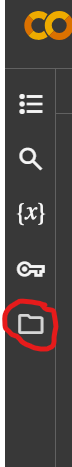

Once selected, the files tab will open, and the user must locate the "housing.csv" shared along with the link to the collaboration. Once the "housing.csv" file has been located on the user's computer, the user must right-click the file and select the "copy as path" option. The final step of the data upload process for the user is determining the "Upload to session storage" icon, pasting the path copied earlier into the "file name" input box and pressing "open".




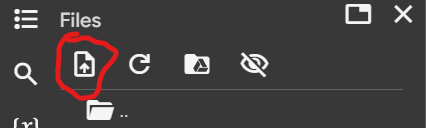

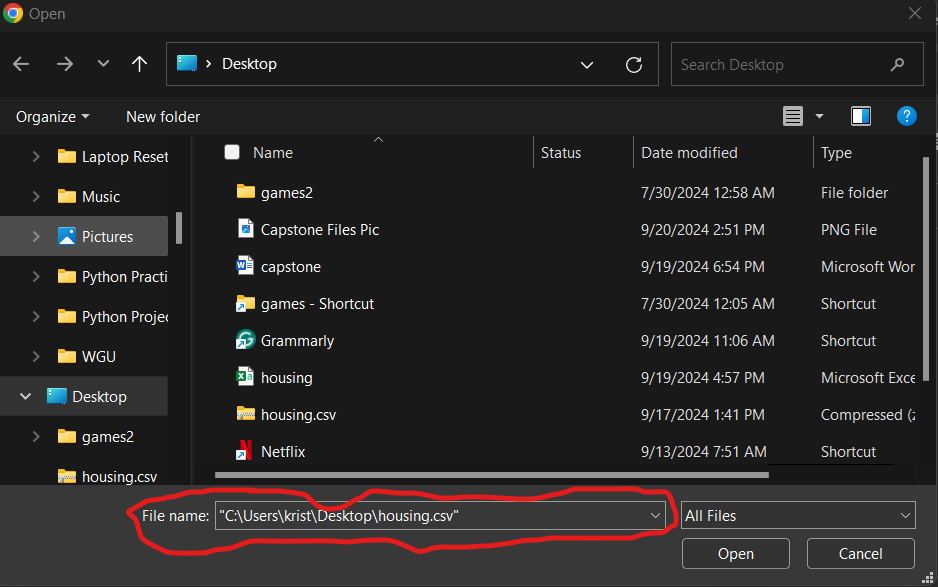

If done correctly the user should be able to see the "housing.csv" file in the "Files" tab. Now the user can run the cell bellow to load the data into the housingData object.

In [ ]:
from pathlib import Path
import pandas as pd


def load_data():
  path = Path("housing.csv")

  return pd.read_csv(path)

housingData = load_data()
housingData.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
#Cell to download data for section D
from google.colab import files

# Save the DataFrame to a CSV file
housingData.to_csv('uncleanedData.csv', index=False)

# Download the file
files.download('uncleanedData.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Preliminary Observations**

Now that the data has been loaded into a pandas data frame, we can use Python's pilot library to visualize the counts of each column in a histogram to understand trends within the housing dataset.

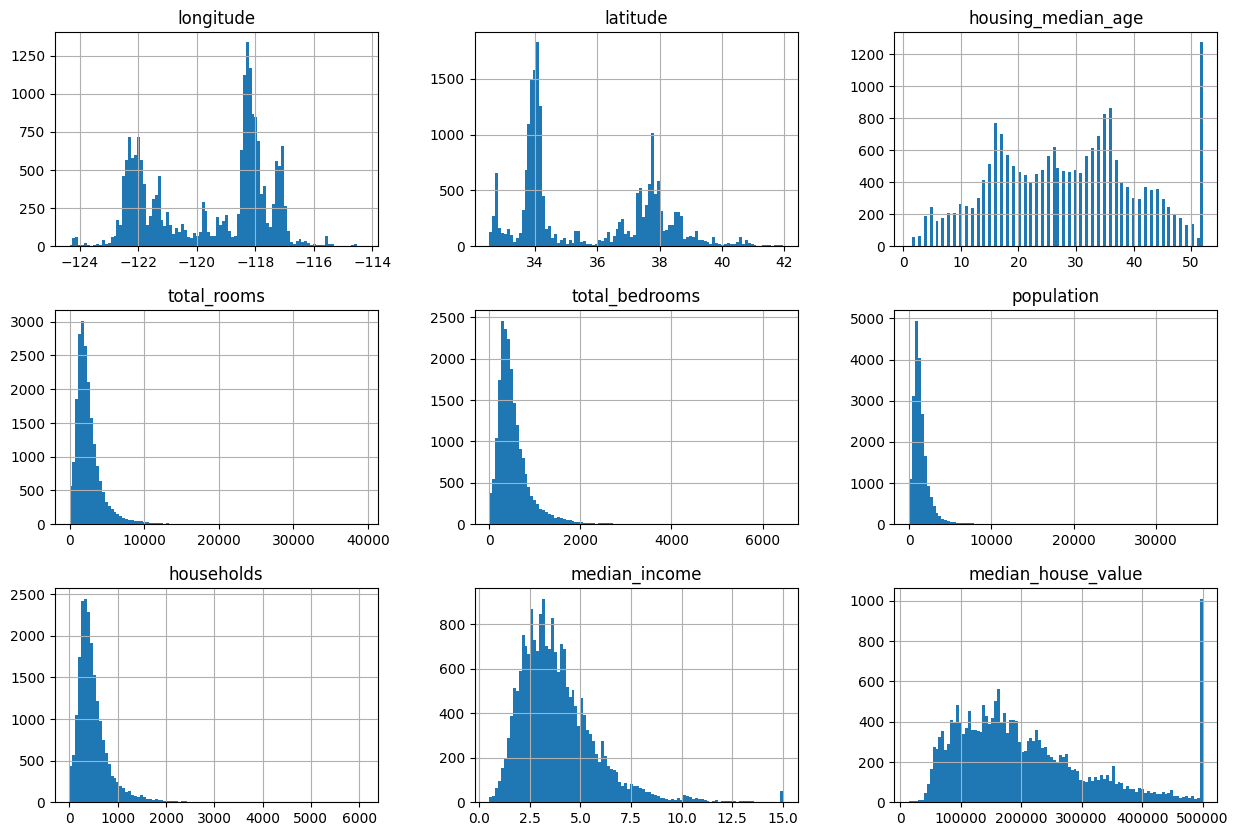

In [ ]:
import matplotlib.pyplot as plt

housingData.hist(bins = 100, figsize = (15,10))
plt.show()

The histograms show that the median_income column is not expressed in USD but in increments of ten thousand dollars (in this case, five would represent $50,000). The second observation that can be made from these histograms is that the housing_median_age and median_housing_value columns may have been capped at 55 and 500,000, respectively. The final observation is that the data seems to be skewed right in most instances.

**Splitting Dataset into Test and Train Segments**

In this project section, we split the dataset into test and train sections for later use. To reduce sampling bias, instead of using a random selection to split the data set, the data set is divided into stratified splits based on income determined by the "median_income" column.

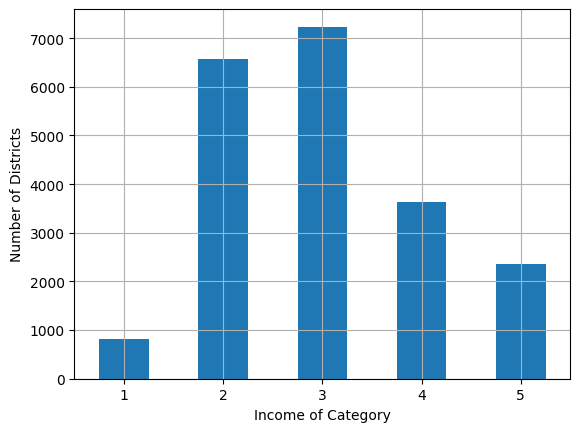

In [ ]:
import numpy as np
#creating an incomeCategory column by dividing median_income column into sections
housingData["incomeCategory"] = pd.cut(housingData['median_income'], bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                                       labels = [1, 2, 3, 4, 5])

#creating a visual representation of new incomeCategory column
housingData["incomeCategory"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income of Category")
plt.ylabel("Number of Districts")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

stratifTrainSet, stratifTestSet = train_test_split(housingData, test_size = 0.2, stratify = housingData['incomeCategory'], random_state = 50)

#visualizing distribution of income category in test set
stratifTestSet['incomeCategory'].value_counts() / len(stratifTestSet)


,count
incomeCategory,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [ ]:
#dropping 'incomeCategory' column since it will not be used past this point
for set_ in (stratifTrainSet, stratifTestSet):
  set_.drop("incomeCategory", axis = 1, inplace = True)

**Data Visualization**

To begin the data visualization section, we will observe the geographical data to find patterns.

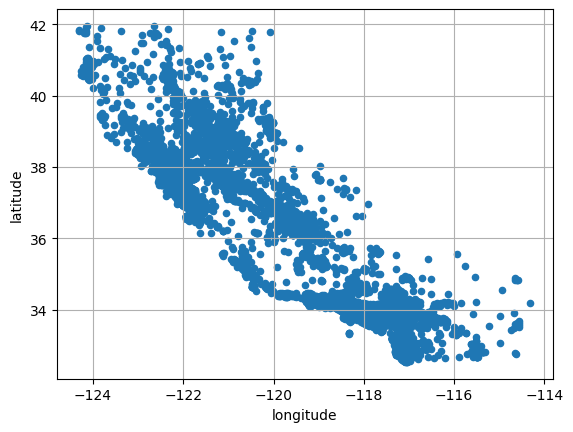

In [ ]:
#copying train set to ensure data is not corrupted during visualization
housingData = stratifTrainSet.copy()

housingData.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True)
plt.show()

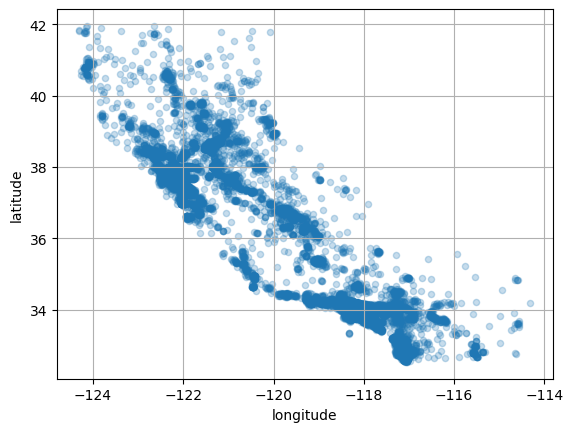

In [ ]:
#to find more patters using alpha parameter allows to see high desity areas of data points
housingData.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True, alpha = 0.25)
plt.show()

From the chart above we can see a majority of data centralized in high-population cities such as San Diego, Los Angeles, and Silicon Valley. Next we will add price to the chart to find if there are any correlations between location and price.

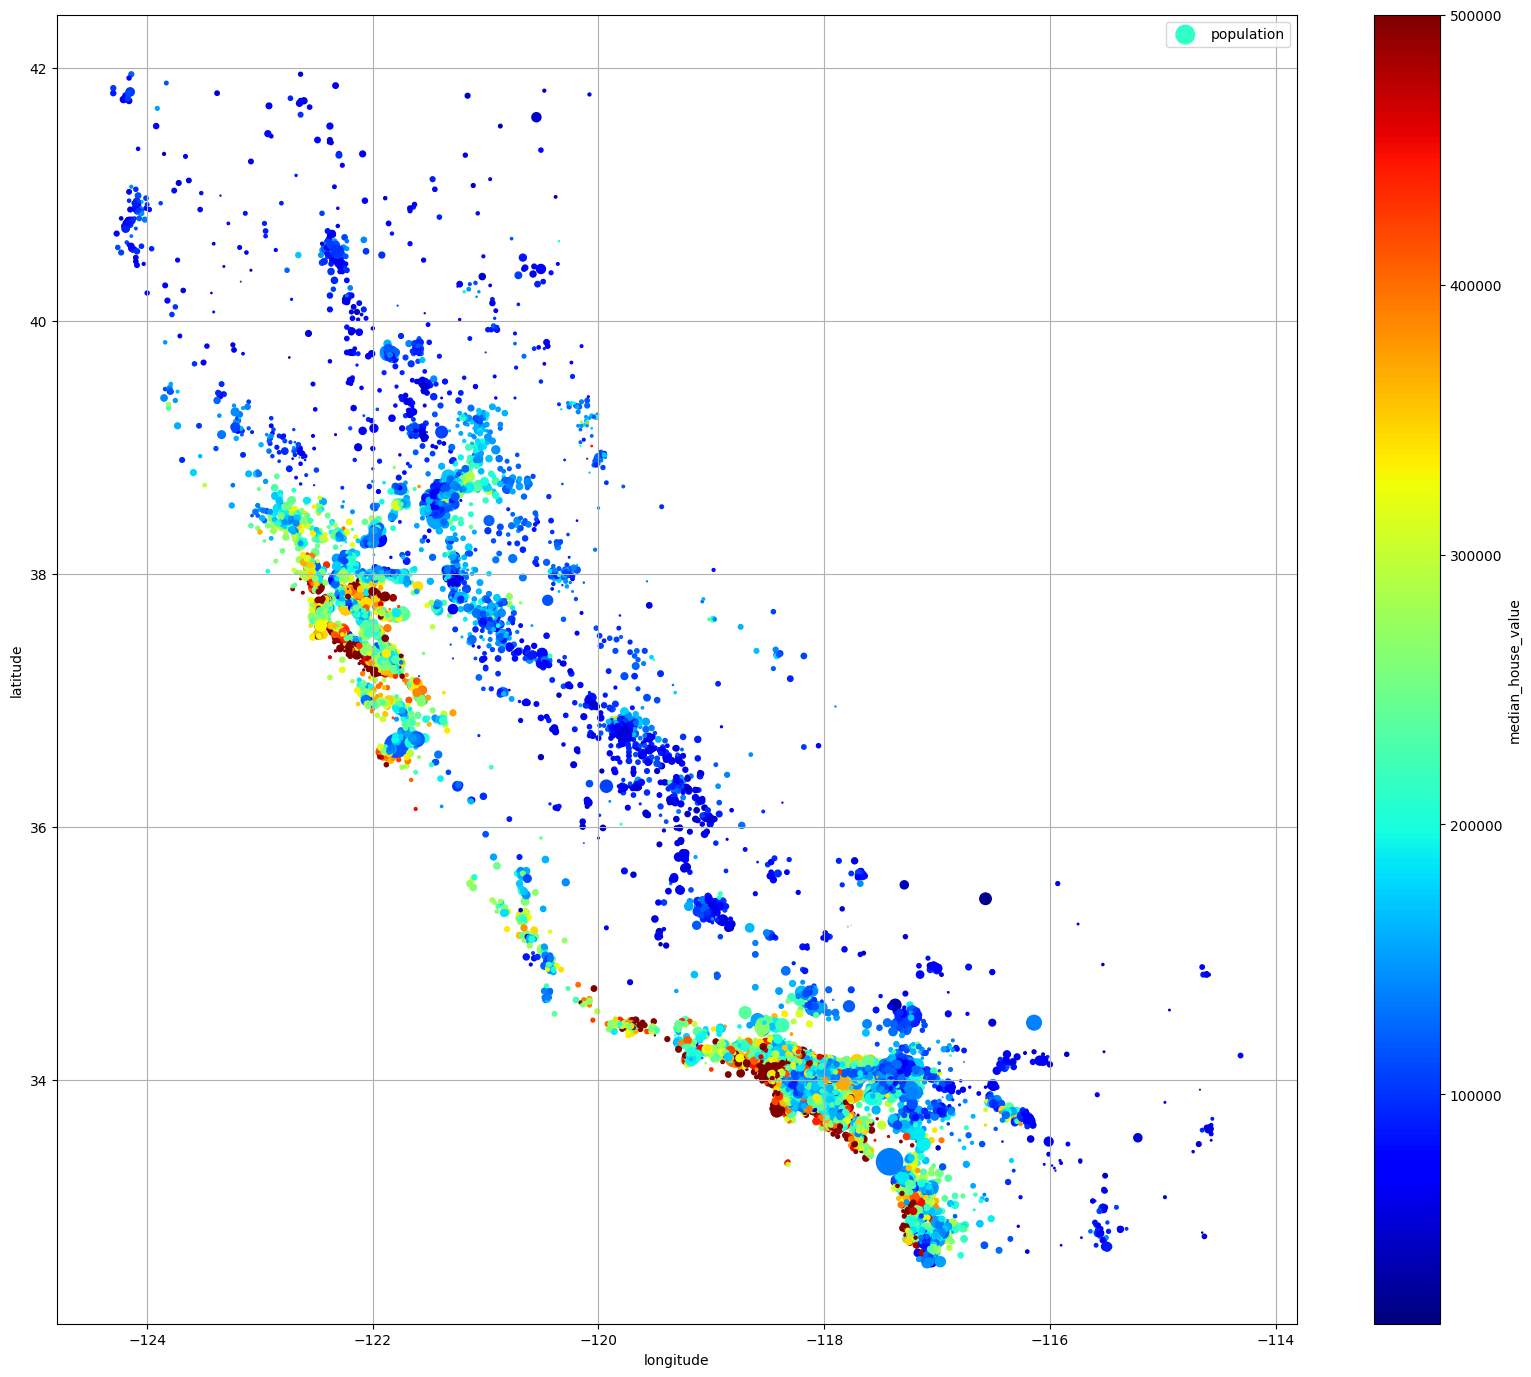

In [ ]:
housingData.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True,
                 s = housingData['population'] / 100, label = 'population',
                 c = 'median_house_value', cmap = 'jet', colorbar = True,
                 legend = True, sharex = False, figsize = (20, 17))
plt.show()

As expected, there is a correlation between price, population, and location, with the city centers identified earlier having the highest cost of housing. To view more correlations we will used pandas' scatter matrix.

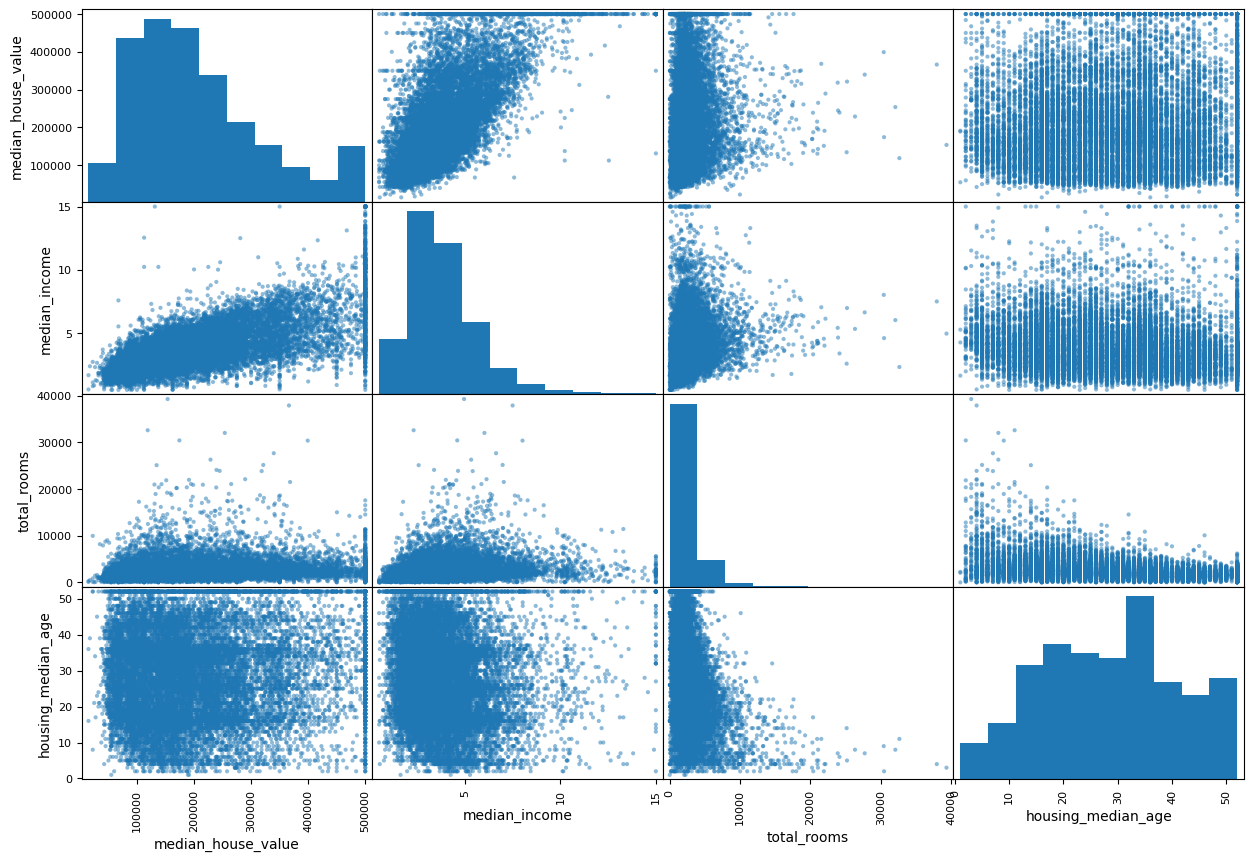

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housingData[attributes], figsize = (15, 10))
plt.show()

From these graphs we can view that median_income seems to have the strongest correlation, so we will enlarge that graph for further exploration.

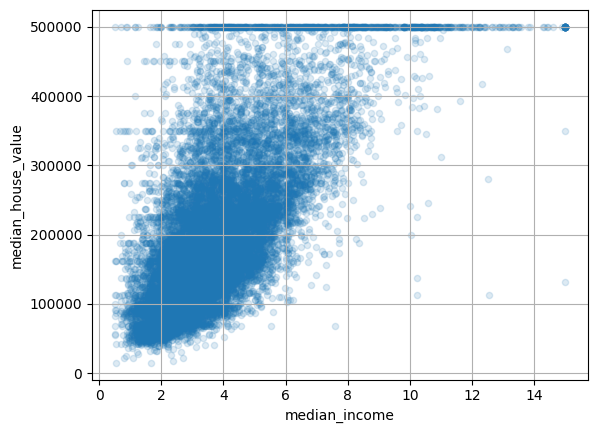

In [ ]:
housingData.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.15, grid = True)
plt.show()

A few things are visible from this graph. First, there is an upward trend as higher incomes tend to lead to high house values. Second, the cap on median housevalue at 500,000 is visible as a horizontal line at the top of the graph. There also seem to be some additional faint horizontal lines around 110,000, 280,000, and 450,000.

One last thing we will test before cleaning the data and training the model is observing a few attribute combinations.

In [ ]:
housingData["roomsPerHouse"] = housingData["total_rooms"] / housingData["households"]
housingData["bedroomsRatio"] = housingData["total_bedrooms"] / housingData["total_rooms"]
housingData["peoplePerHouse"] = housingData["population"] / housingData["households"]

corrMatrix = housingData.drop("ocean_proximity", axis = 1).corr()
corrMatrix["median_house_value"].sort_values(ascending = False)

,median_house_value
median_house_value,1.000000
median_income,0.686977
roomsPerHouse,0.151376
total_rooms,0.137150
housing_median_age,0.103604
households,0.066519
total_bedrooms,0.052712
population,-0.024756
peoplePerHouse,-0.027228
longitude,-0.048672


To understand the correlation matrix, it is essential to know that a value closer to 1 means a strong positive correlation, while a number closer to -1 has a stronger negative correlation. With this in mind, we can observe that bedroomsRatio displays that houses with a lower bedroom-to-room ratio tend to be more expensive. Now that the preliminary data visualization is done, we can clean the dataset for training.

**Cleaning the Data**

To begin the process of cleaning the data, we will revert to the original training sets to reduce any risk of the manipulations we made altering the model. After reverting the data set, we will remove the "median house value" column to separate the labels from predictors.

In [ ]:
housingData = stratifTrainSet.drop("median_house_value", axis = 1)
housingLabels = stratifTrainSet["median_house_value"].copy()

Next, we will remove the corresponding districts to resolve some of the horizontal lines that appeared in the median income vs. median house value chart earlier. To do this, we will use Scikit-Learn's IterativeImpute to modify the training, validation, and test sets.

In [ ]:
from sklearn.experimental import enable_iterative_imputer  # To enable the experimental IterativeImputer
from sklearn.impute import IterativeImputer

housingNumber = housingData.select_dtypes(include=[np.number])
impute = IterativeImputer(max_iter=10, random_state=0)
impute.fit(housingNumber)
X = impute.transform(housingNumber)
print(X)



[[-117.03     33.18     17.     ... 2732.      830.        5.1771]
 [-117.94     33.94     25.     ... 1452.      501.        5.1084]
 [-121.07     39.04      9.     ...  884.      333.        4.5042]
 ...
 [-117.24     32.79     18.     ...  964.      526.        3.4306]
 [-118.37     34.13     28.     ... 1498.      615.        8.5677]
 [-118.43     34.2      28.     ... 2240.      737.        3.0221]]


Since SciKit-Learn outputs NumPy arrays instead of Pandas DataFrames, we will wrap X to revert it to a data frame.

In [ ]:
housingTR = pd.DataFrame(X, columns = housingNumber.columns, index = housingNumber.index)
housingTR.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 15513 to 3721
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


The next step in the data-cleaning process is removing the text and categorical attributes. For instance, the ocean proximity column needs to be transmuted for modeling. To do this, we will use one-hot encoding, which makes the attribute binary, making one instance of the category equal to 1 and the rest equal to 0.





In [ ]:
from sklearn.preprocessing import OneHotEncoder

#storing ocean_proximity column in a variable
housingCat = housingData[["ocean_proximity"]]

catEncoder = OneHotEncoder()
housingOneHotCatEncode = catEncoder.fit_transform(housingCat)
housingOneHotCatEncode.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [ ]:
catEncoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Feature Scaling and Additional Transformations**

One issue that machine learning models tend to Have is that they need help handling Ing datasets with different scales across categories. For example, the housing dataset's rooms attribute can range from 7 to 39,000, while the median income ranges from 0 to 15. To solve this issue in our dataset, we can use the normalization technique Min-max scaler, which rescales a data set to range from 0 to 1. The only problem with the Min-Max scaler is that it handles outliers poorly. Instead, we will use StandardScaler, which adjusts a dataset so that the normalized data represents outliers.

In [ ]:
from sklearn.preprocessing import StandardScaler

standScaler = StandardScaler()
housingStand = standScaler.fit_transform(housingNumber)

The next transformation is adjusting the population attribute with a log-transformer. We make this transformation because machine learning algorithms like linear regression tend to struggle with attributes with heavy-tailed distributions.

In [ ]:
from sklearn.preprocessing import FunctionTransformer

logTransform = FunctionTransformer(np.log, inverse_func = np.exp)
logPop = logTransform.transform(housingData[['population']])

Next, we will create a ClusterSimilarity class that will locate clusters within the data for pattern recognition within the model.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

Since we are making many transformations, using the SciKit-Learns pipeline feature to help streamline the transformations may be helpful.

In [ ]:
from sklearn.pipeline import Pipeline

numberPipeline = Pipeline([
    ("impute", IterativeImputer(max_iter=10, random_state=0)),
    ("standardize", StandardScaler()),
])

Next we will test the created pipelines functionality using the fit_transform() method offered by SciKit-Learn.

In [ ]:
housingPrepared = numberPipeline.fit_transform(housingNumber)
housingPrepared[:2].round(2)

array([[ 1.27, -1.15, -0.93,  1.26,  0.83,  1.14,  0.86,  0.69],
       [ 0.82, -0.79, -0.3 ,  0.28,  0.02,  0.02,  0.  ,  0.65]])

In [ ]:
#converting result to pandas dataframe
housingPreparedDF = pd.DataFrame(housingPrepared, columns = numberPipeline.get_feature_names_out(), index = housingNumber.index)
housingPreparedDF.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
15513,1.269846,-1.149537,-0.929765,1.260139,0.825078,1.137446,0.860356,0.690273
10111,0.815387,-0.793458,-0.295009,0.279367,0.017322,0.018797,0.000222,0.654039
10002,-0.747751,1.596016,-1.564520,-0.121920,-0.396060,-0.477604,-0.438995,0.335369
16700,-0.518024,-0.249970,-0.929765,0.072768,0.233515,0.510828,0.238132,-0.429713
19958,0.126208,0.270092,0.022368,-0.650557,-0.728665,-0.709199,-0.666446,-0.293162


In [ ]:
#Cell to download cleaned data for section D
from google.colab import files

# Save the DataFrame to a CSV file
housingPreparedDF.to_csv('cleanedData.csv', index=False)

# Download the file
files.download('cleanedData.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As we can see from the data frame's output above, through this process, we have standardized and normalized all numerical attributes and removed any null characteristics using an imputer. Now we will combine both categorical and numerical attribute handling into one pipeline to process all data before modeling.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import rbf_kernel


def columnRatio(X):
  return X[:, [0]] / X[:, [1]]

def ratioName(function_transformer, feature_names_in):
  return["ratio"]

def ratioPipeline():
  return make_pipeline(
      IterativeImputer(max_iter=10, random_state=0),
      FunctionTransformer(columnRatio, feature_names_out = ratioName),
      StandardScaler())

# Function to handle non-positive values before applying log
def safe_log_transform(X):
    return np.log(np.maximum(X, 1e-9))


catPipeline = make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown = "ignore"))

logPipeline = make_pipeline(
    IterativeImputer(max_iter=10, random_state=0),
    FunctionTransformer(safe_log_transform, feature_names_out = "one-to-one"),
    StandardScaler())
clusterSimilarity = ClusterSimilarity(n_clusters = 10, gamma = 1., random_state = 50)
defaultNumberPipeline = make_pipeline(IterativeImputer(max_iter=10, random_state=0), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratioPipeline(), ["total_bedrooms", "total_rooms"]),
    ("roomsPerHouse", ratioPipeline(), ["total_rooms", "households"]),
    ("peoplePerHouse", ratioPipeline(), ["population", "households"]),
    #applying log function to attributes that had heavy bias see earlier graphs
    ("log", logPipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", clusterSimilarity, ["latitude", "longitude"]),
    ("cat", catPipeline, make_column_selector(dtype_include = object)),
],
remainder = defaultNumberPipeline)

In [ ]:
housingPreparedData = preprocessing.fit_transform(housingData)
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'roomsPerHouse__ratio', 'peoplePerHouse__ratio',
       'log__total_bedrooms', 'log__total_rooms', 'log__population',
       'log__households', 'log__median_income',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 5 similarity',
       'geo__Cluster 6 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 8 similarity', 'geo__Cluster 9 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

**Training the Model**

Now that the data has been analyzed for patterns and cleaned according to best practices, it is time to train the model. For this application, a random forest regressor model from SciKit-Learn will be used due to its ability to train decision trees on random subsets of features. *Note for this project the evaluation metric will be the root mean squared error

In [ ]:
#Note this cell might take a few minutes to finish loading due to cross validation training the model multiple times
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

forestRegressor = make_pipeline(preprocessing, RandomForestRegressor(random_state = 50))

forestRMSES = -cross_val_score(forestRegressor, housingData, housingLabels, scoring = "neg_root_mean_squared_error", cv = 10)

In [ ]:
pd.Series(forestRMSES).describe()

,0
count,10.000000
mean,46637.673420
std,2396.375709
min,43733.150079
25%,44481.243283
50%,46916.690559
75%,47751.522521
max,50778.139946


This output shows that our model has been successfully trained and has a root mean squared error value of 46637.67. Now that our model is successfully developed we can apply fine-tuning to gather the best result possible.

**Fine-Tuning**

The first fine-tuning method that will be deployed is SciKit-Learn's GridSearch function, which finds the best hyperparameter values for a model to be trained on. Please note that these code cells may take several minutes from now on since the model has been trained multiple times to find the best parameters.

In [ ]:
from sklearn.model_selection import GridSearchCV

fullPipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state = 50)),
])
paramGrid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]}
]
gridSearch = GridSearchCV(fullPipeline, paramGrid, cv = 3, scoring = 'neg_root_mean_squared_error')
gridSearch.fit(housingData, housingLabels)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('iterativeimputer',
                                                                                     IterativeImputer(random_state=0)),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('iterativeimputer',
                                                                                          IterativeImputer(random_state=0)),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x797c814b27a0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=50))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [ ]:
gridSearch.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

Now that we have the best parameters for training, we can evaluate the results to see if they are better than the value of 46637.67 obtained earlier.

In [ ]:
cvRes = pd.DataFrame(gridSearch.cv_results_)
cvRes.sort_values(by = "mean_test_score", ascending = False, inplace = True)
cvRes = cvRes[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
scoreCols = ["split0", "split1", "split2", "mean_test_rmse"]
cvRes.columns = ["n_clusters", "max_features"] + scoreCols
cvRes[scoreCols] = -cvRes[scoreCols].round().astype(np.int64)
cvRes.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43513,43970,44125,43870
13,15,8,43824,44476,44501,44267
14,15,10,43955,44839,45191,44661
7,10,6,44517,45133,45443,45031
9,10,6,44517,45133,45443,45031


The table shows that this tuning improved the error to 43,870 from 46,637. Next, we will attempt to tune the model using the randomized search method, which is similar to the grid search method. Still, instead of searching every possible combination of hyperparameter, it does so randomly.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

paramDistributions = {'preprocessing__geo__n_clusters': randint(low = 3, high = 50),
                      'random_forest__max_features': randint(low = 2, high = 20)}

randSearch = RandomizedSearchCV(
    fullPipeline, param_distributions = paramDistributions, n_iter = 10, cv = 3, scoring = 'neg_root_mean_squared_error', random_state = 50)
randSearch.fit(housingData, housingLabels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('iterativeimputer',
                                                                                           IterativeImputer(random_state=0)),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('iterativeimputer',
                                                                                                IterativeImputer(random_state=0)),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=50))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c793320ccd0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c79336f66b0>},
                   random_state=50, scoring='neg_root_mean_squared_error')

In [ ]:
cv_res = pd.DataFrame(randSearch.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + scoreCols
cv_res[scoreCols] = -cv_res[scoreCols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
8,38,8,41636,42645,42097,42126
2,33,6,41845,42513,42208,42189
6,34,9,41717,42810,42520,42349
0,35,13,42290,43319,43126,42912
1,48,3,43134,43624,43288,43349


From this round of tuning, we have determined that using the value of 38 for n_clusters and eight max_features delivered the best hyperparameters for results. This test delivered a score of 42,126 compared to GridSearch's 43,870.

In [ ]:
finalModel = randSearch.best_estimator_

**Evaluation Portion**

 Now that we have the best possible model, it is time to evaluate it on the test set.

In [ ]:
Xtest = stratifTestSet.drop("median_house_value", axis = 1)
yTest = stratifTestSet["median_house_value"].copy()

finalPreds = finalModel.predict(Xtest)

finalRMSE = mean_squared_error(yTest, finalPreds, squared = False)
print(finalRMSE)

41948.510553991466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


With this our model has been thoroughly trained, validated, and tested. The final error for this version of the housing price prediction tool was 41,948.

**Section for Customers of Olsen Realty**

Greetings, a valued customer of Olsean Realty. In the above sections, we displayed how our housing price prediction system was trained and developed to deliver the most accurate quote for your home. In the cell below, the customer should enter their home's values for the longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, household, median_income, and ocean_proximity variables. It is important to note for the customer that the housing_median_age, total_rooms, total_bedrooms, population, households (number of families), and median_income are all pertaining to a per block basis. This would mean that the user should enter the median house age of For Their block in the housing_median_age field, or for the total_rooms field, a user should estimate how many rooms are in buildings on their block. It is important to note that this tool was trained on data provided by the California Census Bureau in the 1990s, so prices may not be accurate in current-day prices. *Note: customers should not input values for houses outside of California to keep predictions as accurate as possible.

In [ ]:
#Creting a new DataFrame for customer data
customerDF = pd.DataFrame(columns=Xtest.columns)
#If you are a customer, please enter the values corresponding to your property below
new_row = pd.DataFrame({
    #Enter longitude of your home in brackets bellow
    'longitude': [-118.39],
    #Enter latitude of your home in brackets bellow
    'latitude': [34.17],
    #Enter the meadian age of houses on your block in the brackets bellow
    'housing_median_age': [40.0],
    #Enter the total number of rooms on your block in the brackets bellow
    'total_rooms': [1696.0],
    #Enter the total number of bedrooms on your block in the brackets bellow
    'total_bedrooms': [372.0],
    #Enter an estimate of the population of your block in the brackets bellow
    'population': [835.0],
    #Enter the number of households on your block in the brackets bellow
    'households': [385.0],
    #Enter an estimate of the median income (standardized to single digits) on your block bellow
    'median_income': [3.6563],
    #Enter the proximity to the ocean in the bracket bellow in the form of <1H OCEAN, INLAND, ISLAND, NEAR BAY, or NEAR OCEAN
    'ocean_proximity': ['<1H OCEAN']
})
customerDF = pd.concat([customerDF, new_row], ignore_index=True)

customerDF.head()

<ipython-input-90-c3f6125dd364>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  customerDF = pd.concat([customerDF, new_row], ignore_index=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.39,34.17,40.0,1696.0,372.0,835.0,385.0,3.6563,<1H OCEAN


To ensure the best possible prediction, please ensure that the information you entered is correctly displayed in the table above.

In [ ]:
customerPrediction = finalModel.predict(customerDF)
print("Based on our calculations Olsen Realty values your home at:")
print(customerPrediction[0])

Based on our calculations Olsen Realty values your home at:
286056.01


Please view the supplementary graphs below to help the customer further understand our quote.

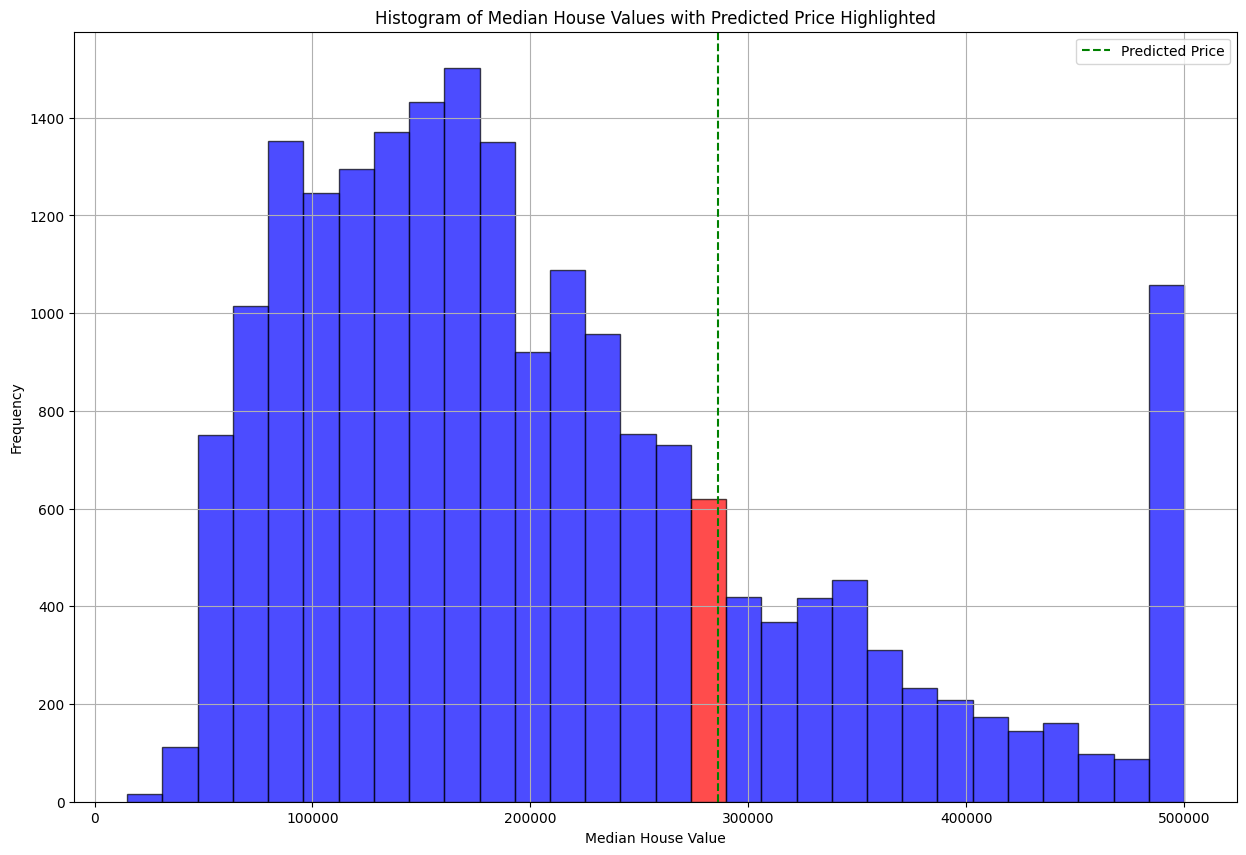

In [ ]:
import matplotlib.pyplot as plt

compareDF = pd.read_csv('housing.csv')


predicted_price = customerPrediction[0]  # Get the predicted price

#Creating a histogram of the median house values
plt.figure(figsize=(15, 10))
counts, bins, patches = plt.hist(compareDF['median_house_value'], bins=30, color='blue', alpha=0.7, edgecolor='black')

#Finding the bin that contains the predicted price
bin_index = np.digitize(predicted_price, bins) - 1

#Highlighting the bin containing the predicted price
if 0 <= bin_index < len(patches):
    patches[bin_index].set_facecolor('red')  # Change the color of the bin to red

#title and labels
plt.title('Histogram of Median House Values with Predicted Price Highlighted')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')

#Adding a vertical line for the predicted price
plt.axvline(x=predicted_price, color='green', linestyle='--', label='Predicted Price')

plt.legend()


plt.grid(True)
plt.show()


In the histogram above, the user can see where their quoted price would be in context with the other houses in the California housing dataset.

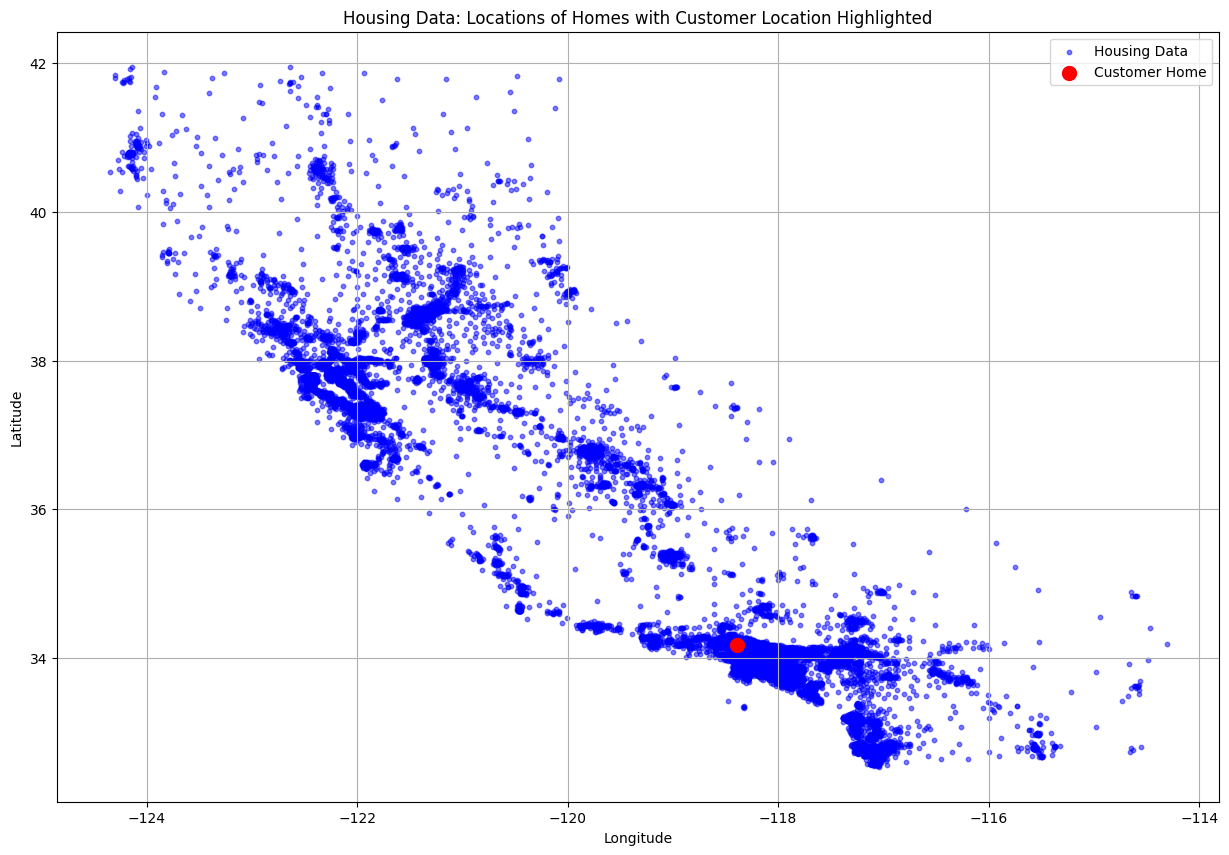

In [ ]:
#Extracting longitude and latitude from the housingData DataFrame
longitudes = compareDF['longitude']
latitudes = compareDF['latitude']

#Extracting the customer's home location
customer_longitude = customerDF['longitude'][0]
customer_latitude = customerDF['latitude'][0]

#Creating a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5, label='Housing Data', s=10)  # Scatter plot for housing data
plt.scatter(customer_longitude, customer_latitude, color='red', label='Customer Home', s=100)  # Highlight customer home

#title and labels
plt.title('Housing Data: Locations of Homes with Customer Location Highlighted')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()


plt.grid(True)
plt.show()

The scatter plot above the user's home location is plotted on a graph along with all other home locations in the dataset used to train Olsen Realty's housing price prediction system.

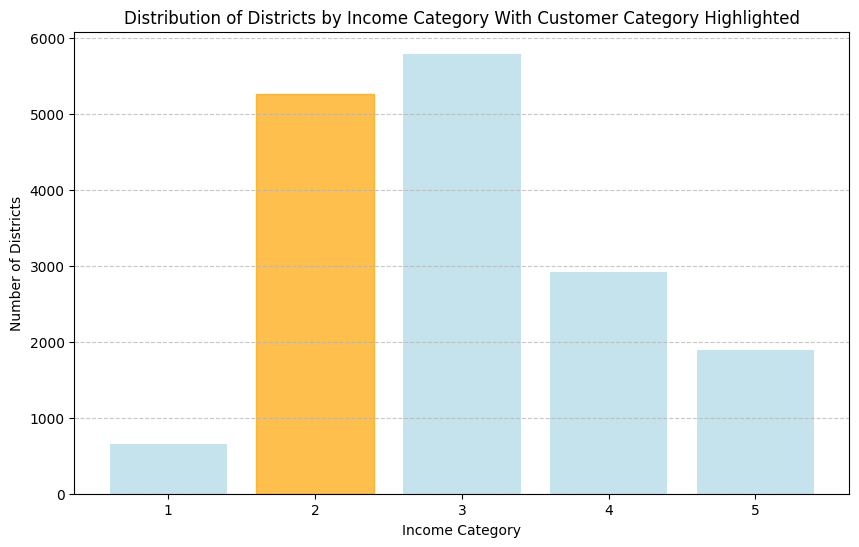

In [ ]:
#Creating the incomeCategory column in housingData
housingData["incomeCategory"] = pd.cut(
    housingData['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

#Getting the customer's income and find their income category
customer_income = customerDF['median_income'][0]
customer_income_category = pd.cut(
    [customer_income],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
).categories[0]

#Creating a count of the number of districts in each income category
income_counts = housingData["incomeCategory"].value_counts().sort_index()

#Creating bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(income_counts.index.astype(str), income_counts.values, color='lightblue', alpha=0.7)

#Highlighting the customer's income category in a different color
for bar in bars:
    if int(bar.get_x() + 0.5) == customer_income_category:  # Highlight the bar for the customer's category
        bar.set_color('orange')

#labels and title
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.title("Distribution of Districts by Income Category With Customer Category Highlighted")



plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The histogram above breaks down income into categories, which are then used as bins to create the histogram. The bin the customer's income category falls into is highlighted in gold for distribution purposes.

Thank you for using Olsen Realty's housing price prediction tool, developed using machine learning technology. In this project, the housing dataset provided by the California Census Bureau was analyzed to find essential attributes, then cleaned and modified for model training that would eventually become the housing price prediction tool. In the final section, the customer inputs their home's information and then has a quote provided by the system, which finally provides some context to the quote provided.